# Film Development Time Prediction

End-to-end orchestration of the pipeline:

1. Data loading & exploration
2. Frozen train/val/test splits
3. Feature engineering walkthrough (slopes → latent vectors → aggregates)
4. 5-fold cross-validation with ExtraTreesRegressor
5. Final model: train on all trainval, evaluate on held-out test
6. Feature importance & error analysis

In [28]:
%pip install numpy pandas matplotlib scikit-learn optuna

  Using cached optuna-4.7.0-py3-none-any.whl.metadata (17 kB)
  Using cached colorlog-6.10.1-py3-none-any.whl.metadata (11 kB)
  Using cached sqlalchemy-2.0.46-cp311-cp311-win_amd64.whl.metadata (9.8 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached pyyaml-6.0.3-cp311-cp311-win_amd64.whl.metadata (2.4 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached greenlet-3.3.1-cp311-cp311-win_amd64.whl.metadata (3.8 kB)
  Using cached markupsafe-3.0.3-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
Using cached optuna-4.7.0-py3-none-any.whl (413 kB)
   ---------------------------------------- 0.0/263.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/263.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/263.9 kB 435.7 kB/s eta 0:00:01
   ----------------- ---------------------- 112.6/263.9 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- - 256.0/263.9 kB 1.8 MB/s eta 0:00:01
   --------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: c:\Users\cierl\.pyenv\pyenv-win\versions\3.11.9\python.exe -m pip install --upgrade pip


In [55]:
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet

from data_split import DataSplitter, prepare_data
from film_slopes import FilmSlopeEstimator, DevDilSlopeEstimator, DevDilutionSlopeEstimator
from latent_features import LatentFeatureBuilder
from aggregate_features import AggregateFeatureBuilder
from train_extratrees import build_features, smape, evaluate, DROP_COLS, TARGET

%matplotlib inline
plt.rcParams.update({'figure.dpi': 110, 'axes.spines.top': False, 'axes.spines.right': False})

## 1. Data Loading & Exploration

In [3]:
print("=" * 60)
print("Filtering pipeline")
print("=" * 60)
df = prepare_data("film_data.csv")

print(f"""
Final dataset
  Rows        : {len(df):,}
  Films       : {df['Film'].nunique():,}
  Developers  : {df['Developer'].nunique():,}
  dev_dils    : {df['dev_dil'].nunique():,}
  Time range  : {df['35mm'].min():.1f} – {df['35mm'].max():.1f} min
  ISO range   : {df['iso'].min():.0f} – {df['iso'].max():.0f}
""")
df.head(3)

Filtering pipeline
  Time filter (3.0–30.0 min): 13163 → 11782 (removed 1381)
  Unusual processes removed: 460 → 11322 remaining
  Invalid ISO removed: 96 → 11226 remaining
  No box ISO removed: 0 → 11226 remaining

Final dataset
  Rows        : 11,226
  Films       : 243
  Developers  : 213
  dev_dils    : 627
  Time range  : 3.0 – 30.0 min
  ISO range   : 0 – 25000



,Film,Developer,Dilution,ASA/ISO,35mm,120,Sheet,Temp,Notes,iso,dev_dil,box_iso,stops
0,CHM 100 Universal,510-Pyro,1+100,100,11.75,NaN,NaN,20C,NaN,100.0,510-Pyro 1+100,100.0,0.000000
1,CHM 100 Universal,Adox HR-DEV,1+35,160,10.00,NaN,NaN,20C,"Agitation: continuous first 30 secs, then 1-2 ...",160.0,Adox HR-DEV 1+35,100.0,0.678072
2,CHM 100 Universal,Atomal 49,1+2,100,22.00,NaN,NaN,20C,NaN,100.0,Atomal 49 1+2,100.0,0.000000


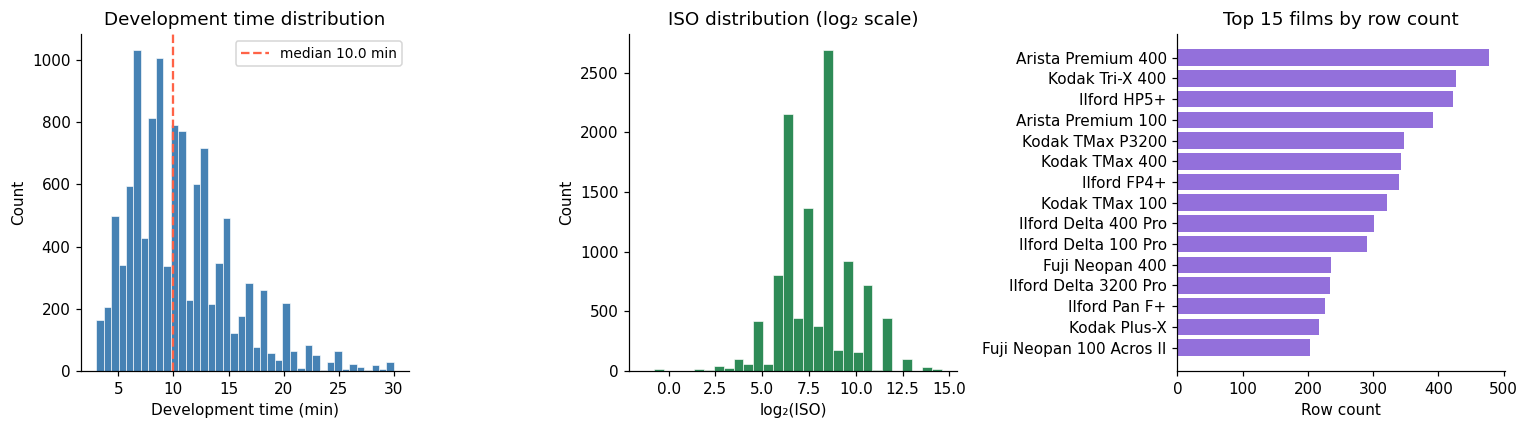

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Development time distribution
axes[0].hist(df['35mm'], bins=40, color='steelblue', edgecolor='white', linewidth=0.4)
axes[0].set_xlabel('Development time (min)')
axes[0].set_ylabel('Count')
axes[0].set_title('Development time distribution')
axes[0].axvline(df['35mm'].median(), color='tomato', linestyle='--', label=f"median {df['35mm'].median():.1f} min")
axes[0].legend(fontsize=9)

# ISO distribution
iso_counts = np.log2(df['iso']).round(1)
axes[1].hist(iso_counts, bins=30, color='seagreen', edgecolor='white', linewidth=0.4)
axes[1].set_xlabel('log₂(ISO)')
axes[1].set_ylabel('Count')
axes[1].set_title('ISO distribution (log₂ scale)')

# Top 15 films by row count
top_films = df['Film'].value_counts().head(15)
axes[2].barh(top_films.index[::-1], top_films.values[::-1], color='mediumpurple')
axes[2].set_xlabel('Row count')
axes[2].set_title('Top 15 films by row count')

plt.tight_layout()
plt.show()

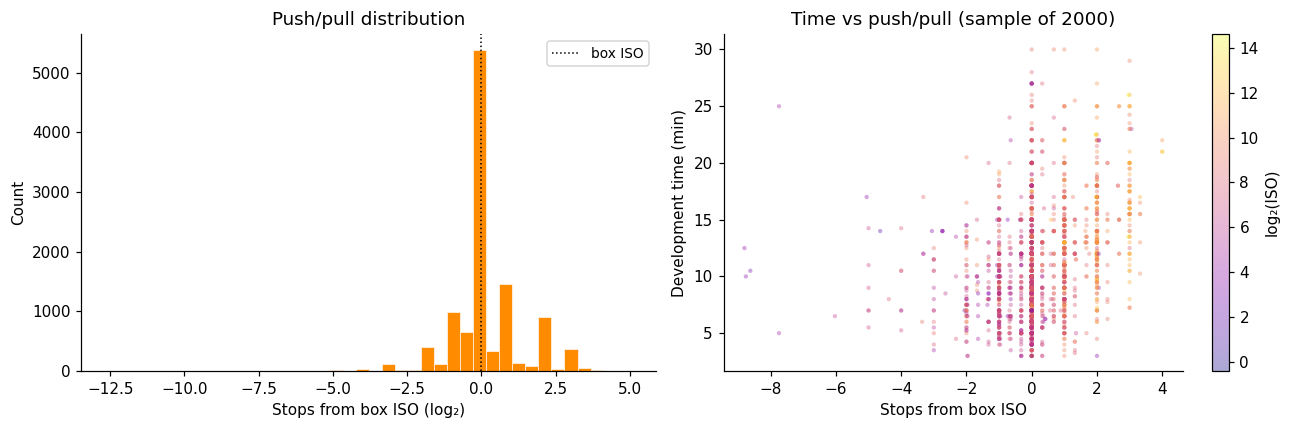

In [5]:
# Stops (push/pull) distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['stops'], bins=40, color='darkorange', edgecolor='white', linewidth=0.4)
axes[0].set_xlabel('Stops from box ISO (log₂)')
axes[0].set_ylabel('Count')
axes[0].set_title('Push/pull distribution')
axes[0].axvline(0, color='black', linestyle=':', linewidth=1, label='box ISO')
axes[0].legend(fontsize=9)

# Time vs stops scatter (sample)
sample = df.sample(min(2000, len(df)), random_state=0)
sc = axes[1].scatter(sample['stops'], sample['35mm'], c=np.log2(sample['iso']),
                     cmap='plasma', alpha=0.35, s=8, linewidths=0)
plt.colorbar(sc, ax=axes[1], label='log₂(ISO)')
axes[1].set_xlabel('Stops from box ISO')
axes[1].set_ylabel('Development time (min)')
axes[1].set_title('Time vs push/pull (sample of 2000)')

plt.tight_layout()
plt.show()

## 2. Train/Val/Test Splits

In [6]:
splitter = DataSplitter.load("splits.json")

print(f"Seed          : {splitter.seed}")
print(f"N folds       : {splitter.n_folds}")
print(f"Test fraction : {splitter.test_fraction}")
print(f"Test rows     : {len(splitter.test_indices):,}")
print(f"Trainval rows : {len(splitter.get_trainval_indices()):,}")
print()

summary = splitter.summary(df)
display(summary[['set', 'n_rows', 'pct_total', 'n_films', 'n_dev_dils',
                  'time_median', 'time_mean', 'time_std']].round(2))

Seed          : 42
N folds       : 5
Test fraction : 0.2
Test rows     : 2,243
Trainval rows : 8,983



,set,n_rows,pct_total,n_films,n_dev_dils,time_median,time_mean,time_std
0,test,2243,19.98,218,362,10.0,10.60,4.56
1,fold_0_train,7076,63.03,208,541,10.0,10.74,4.73
2,fold_0_val,1907,16.99,243,332,10.0,10.72,4.73
3,fold_1_train,7148,63.67,243,538,10.0,10.70,4.71
4,fold_1_val,1835,16.35,208,327,10.0,10.88,4.81
5,fold_2_train,7184,63.99,243,541,10.0,10.78,4.75
6,fold_2_val,1799,16.03,202,329,10.0,10.57,4.66
7,fold_3_train,7239,64.48,243,550,10.0,10.76,4.73
8,fold_3_val,1744,15.54,185,311,10.0,10.65,4.71
9,fold_4_train,7285,64.89,243,555,10.0,10.71,4.73


In [7]:
# Verify no leakage
test_set = set(splitter.test_indices)
all_folds = [set(f) for f in splitter.fold_indices]

for i, fold in enumerate(all_folds):
    assert len(test_set & fold) == 0, f"Test overlaps fold {i}"
for i in range(len(all_folds)):
    for j in range(i + 1, len(all_folds)):
        assert len(all_folds[i] & all_folds[j]) == 0, f"Fold {i} overlaps fold {j}"

all_assigned = test_set.copy()
for fold in all_folds:
    all_assigned |= fold
assert len(all_assigned) == len(df)

print("Split integrity checks passed:")
print("  No test/fold overlap")
print("  No fold/fold overlap")
print(f"  All {len(df):,} rows accounted for")

Split integrity checks passed:
  No test/fold overlap
  No fold/fold overlap
  All 11,226 rows accounted for


## 3. Feature Engineering Walkthrough (Fold 0)

All transformers are fit on the **training fold only** to prevent leakage.

### 3a. Slope Estimation

In [8]:
train_idx, val_idx = splitter.get_fold(0)
df_train0 = df.loc[train_idx]
df_val0   = df.loc[val_idx]

# Fit all three slope estimators on training fold
film_est  = FilmSlopeEstimator().fit(df_train0)
devdil_est = DevDilSlopeEstimator(box_isos=film_est.box_isos).fit(df_train0)
dil_est   = DevDilutionSlopeEstimator().fit(df_train0)

print(f"FilmSlopeEstimator     : {len(film_est.film_slopes):,} films with specific slope  "
      f"(global={film_est.global_slope:.4f})")
print(f"DevDilSlopeEstimator   : {len(devdil_est.dev_dil_slopes):,} dev_dils with specific slope  "
      f"(global={devdil_est.global_slope:.4f})")
print(f"DevDilutionSlopeEstimator: {len(dil_est.dev_dilution_slopes):,} developers with dilution slope  "
      f"(global={dil_est.global_slope:.4f})")

FilmSlopeEstimator     : 80 films with specific slope  (global=0.1457)
DevDilSlopeEstimator   : 106 dev_dils with specific slope  (global=0.1306)
DevDilutionSlopeEstimator: 48 developers with dilution slope  (global=0.0113)


In [9]:
# Film slope summary — top 10 most-observed films
fs = film_est.summary().sort_values('n_devs', ascending=False)
print("Top 10 films by developer count:")
display(fs[['Film','slope','accel','se','r2_within','n_obs','n_devs','box_iso']].head(10).round(4))

Top 10 films by developer count:


,Film,slope,accel,se,r2_within,n_obs,n_devs,box_iso
41,Ilford HP5+,0.1957,0.0163,0.0120,0.8458,161,53,400.0
16,Arista Premium 400,0.1463,0.0119,0.0056,0.8754,240,50,400.0
57,Kodak Tri-X 400,0.1466,0.0190,0.0107,0.7747,148,45,400.0
40,Ilford FP4+,0.1804,0.0055,0.0142,0.7648,119,42,125.0
15,Arista Premium 100,0.1128,0.0298,0.0061,0.9216,205,41,100.0
39,Ilford Delta 400 Pro,0.2880,0.0000,0.0167,0.8746,120,39,400.0
37,Ilford Delta 100 Pro,0.1442,0.0157,0.0110,0.7967,107,35,100.0
34,Fuji Neopan 1600,0.1736,0.0138,0.0174,0.6928,87,31,1600.0
35,Fuji Neopan 400,0.1285,0.0298,0.0120,0.8382,97,31,400.0
56,Kodak TMax P3200,0.1375,0.0043,0.0068,0.8274,141,31,3200.0


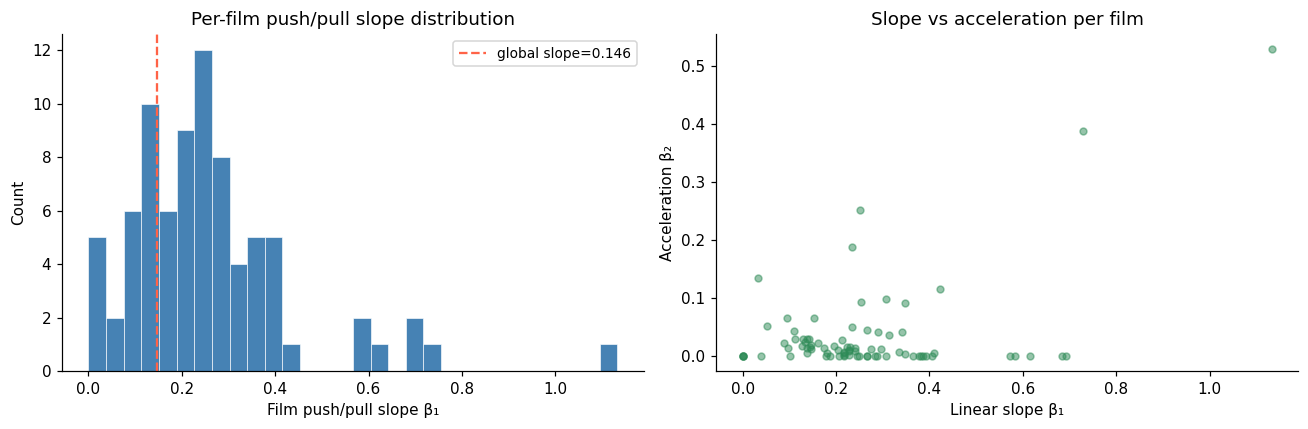

In [10]:
# Visualise film slope distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(fs['slope'], bins=30, color='steelblue', edgecolor='white', linewidth=0.4)
axes[0].axvline(film_est.global_slope, color='tomato', linestyle='--',
                label=f'global slope={film_est.global_slope:.3f}')
axes[0].set_xlabel('Film push/pull slope β₁')
axes[0].set_ylabel('Count')
axes[0].set_title('Per-film push/pull slope distribution')
axes[0].legend(fontsize=9)

axes[1].scatter(fs['slope'], fs['accel'], alpha=0.5, s=20, color='seagreen')
axes[1].set_xlabel('Linear slope β₁')
axes[1].set_ylabel('Acceleration β₂')
axes[1].set_title('Slope vs acceleration per film')

plt.tight_layout()
plt.show()

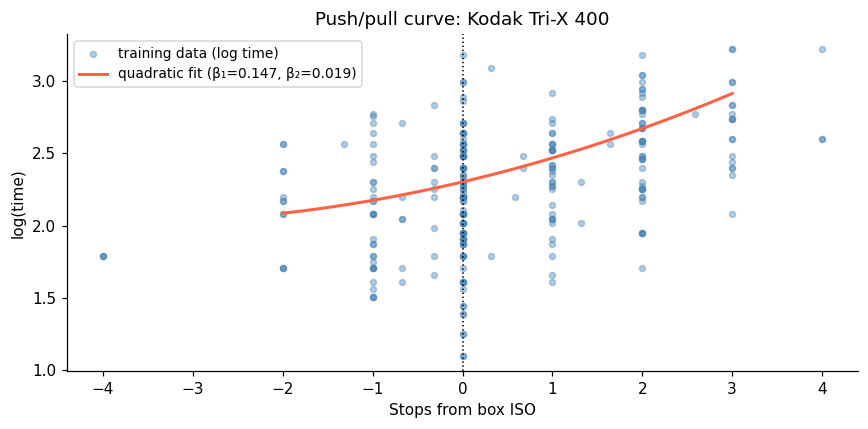

In [11]:
# Visualise a well-known film's push/pull curve
candidate_films = [f for f in ['Ilford HP5 Plus 400', 'Kodak Tri-X 400', 'Ilford Delta 400 Professional',
                                'Kodak T-Max 400'] if f in film_est.film_slopes]
if candidate_films:
    film_name = candidate_films[0]
    info = film_est.film_slopes[film_name]
    stops_range = np.linspace(-2, 3, 80)
    log_ratio = info['slope'] * stops_range + info['accel'] * stops_range**2

    # Raw data points
    film_rows = df_train0[df_train0['Film'] == film_name]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(film_rows['stops'], np.log(film_rows['35mm']), alpha=0.4, s=15,
               color='steelblue', label='training data (log time)')
    ax.plot(stops_range, log_ratio + np.log(film_rows['35mm'].median()), color='tomato',
            linewidth=2, label=f'quadratic fit (β₁={info["slope"]:.3f}, β₂={info["accel"]:.3f})')
    ax.set_xlabel('Stops from box ISO')
    ax.set_ylabel('log(time)')
    ax.set_title(f'Push/pull curve: {film_name}')
    ax.legend(fontsize=9)
    ax.axvline(0, color='black', linestyle=':', linewidth=1)
    plt.tight_layout()
    plt.show()
else:
    print("None of the target films found in fold 0 training data.")

### 3b. Matrix Factorization (Latent Features)

In [12]:
lv = LatentFeatureBuilder(n_factors=30, reg=0.005)
lv_train0 = lv.fit_transform(df_train0)
lv_val0   = lv.transform(df_val0)

info = lv.summary()
print(f"Matrix shape  : {info['matrix_shape'][0]} dev_dils × {info['matrix_shape'][1]} film@ISO columns")
print(f"Matrix density: {info['density']:.1%}")
print(f"Filled cells  : {info['filled_cells']:,}")
print(f"Recon SMAPE   : {info['recon_smape']:.2f}%")
print(f"Recon R²      : {info['recon_r2']:.4f}")
print(f"Films with LV : {info['n_films_with_lv']}")
print(f"Dev_dils w/ LV: {info['n_dd_with_lv']}")
print(f"Global mean   : {info['global_mean_time']:.2f} min")
print(f"\nLV columns ({lv_train0.shape[1]}):")
print(', '.join(lv_train0.columns[:6].tolist()), '...',
      ', '.join(lv_train0.columns[-3:].tolist()))

Matrix shape  : 236 dev_dils × 289 film@ISO columns
Matrix density: 6.4%
Filled cells  : 4,375
Recon SMAPE   : 1.35%
Recon R²      : 0.9975
Films with LV : 168
Dev_dils w/ LV: 236
Global mean   : 9.58 min

LV columns (66):
lv_global_mean, lv_dd_bias, lv_film_bias, lv_dd_0, lv_film_0, lv_dd_1 ... lv_available, lv_pred_log, lv_pred_time


In [13]:
# Coverage on val
val_cov = lv_val0['lv_available'].mean()
print(f"Val LV coverage : {val_cov:.1%} ({lv_val0['lv_available'].sum()} / {len(lv_val0)} rows)")

# MF-only SMAPE on covered val rows
mask = lv_val0['lv_available']
if mask.sum() > 0:
    actual    = df_val0.loc[mask, '35mm'].values
    predicted = lv_val0.loc[mask, 'lv_pred_time'].values
    mf_smape  = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100
    mf_mae    = np.mean(np.abs(actual - predicted))
    print(f"MF-only val SMAPE: {mf_smape:.2f}%  MAE: {mf_mae:.2f} min  (on {mask.sum()} rows)")

Val LV coverage : 87.7% (1673 / 1907 rows)
MF-only val SMAPE: 22.60%  MAE: 2.47 min  (on 1673 rows)


### 3c. Aggregate Features

In [14]:
agg = AggregateFeatureBuilder()
agg_train0 = agg.fit_transform(df_train0)
agg_val0   = agg.transform(df_val0)

s = agg.summary()
print(f"Entity levels   : {s['entity_levels']}  (film, film@ISO, dev_dil, developer)")
print(f"Stats per entity: {s['features_per_entity']}")
print(f"Row features    : {s['row_features']}")
print(f"Total features  : {s['total_features']}")
print(f"\nEntities seen in training:")
print(f"  Films     : {s['n_films']}")
print(f"  Film@ISO  : {s['n_film_iso']}")
print(f"  Dev_dils  : {s['n_dev_dils']}")
print(f"  Developers: {s['n_developers']}")

# Coverage
for prefix, label in [('film_agg', 'Film'), ('film_iso_agg', 'Film@ISO'),
                       ('dd_agg', 'Dev_dil'), ('dev_agg', 'Developer')]:
    col = f'{prefix}_count'
    cov = agg_val0[col].notna().mean() * 100
    print(f"  Val coverage {label:10s}: {cov:.1f}%")

Entity levels   : 4  (film, film@ISO, dev_dil, developer)
Stats per entity: 12
Row features    : 2
Total features  : 50

Entities seen in training:
  Films     : 208
  Film@ISO  : 924
  Dev_dils  : 541
  Developers: 196
  Val coverage Film      : 98.2%
  Val coverage Film@ISO  : 94.1%
  Val coverage Dev_dil   : 97.3%
  Val coverage Developer : 99.3%


### 3d. Combined Feature Matrix

In [15]:
X_train0, y_train0, X_val0, y_val0, feature_names = build_features(df_train0, df_val0)

print(f"X_train shape : {X_train0.shape}")
print(f"X_val shape   : {X_val0.shape}")
print(f"\nNaN fraction per split:")
print(f"  train : {np.isnan(X_train0).mean():.2%}")
print(f"  val   : {np.isnan(X_val0).mean():.2%}")
print(f"\nFirst 10 feature names: {feature_names[:10]}")

X_train shape : (7076, 136)
X_val shape   : (1907, 136)

NaN fraction per split:
  train : 3.01%
  val   : 5.21%

First 10 feature names: ['box_iso', 'stops', 'stops_from_box', 'film_slope', 'film_accel', 'film_slope_se', 'film_slope_r2', 'film_slope_n_devs', 'film_slope_pred_log_ratio', 'dev_dil_slope']


## 4. Cross-Validation

In [59]:
print("=" * 70)
print("5-Fold Cross-Validation — ExtraTreesRegressor")
print("=" * 70)

fold_results = []

for fold in range(splitter.n_folds):
    train_idx, val_idx = splitter.get_fold(fold)
    df_train = df.loc[train_idx]
    df_val   = df.loc[val_idx]

    t0 = time.time()
    X_train, y_train, X_val, y_val, feat_names = build_features(df_train, df_val)
    t_feat = time.time() - t0

    t0 = time.time()
    et = RandomForestRegressor(
        n_estimators=100, max_features=0.05,
        min_samples_split=20, random_state=42, n_jobs=-1,
    )
    et.fit(X_train, y_train)
    t_train = time.time() - t0

    y_pred_train = et.predict(X_train)
    y_pred_val   = et.predict(X_val)

    print(f"\nFold {fold}  (feat: {t_feat:.0f}s  train: {t_train:.0f}s  features: {X_train.shape[1]})")
    evaluate(y_train, y_pred_train, 'train')
    res = evaluate(y_val, y_pred_val, 'val')
    fold_results.append({'fold': fold, **res, 'n_val': len(y_val)})

print()
cv_df = pd.DataFrame(fold_results)
print("=" * 70)
print("CV Summary")
print("=" * 70)
for metric in ['smape', 'mae', 'mape', 'r2']:
    vals = cv_df[metric]
    print(f"  {metric:8s}  mean={vals.mean():.4f}  std={vals.std():.4f}  "
          f"min={vals.min():.4f}  max={vals.max():.4f}")

5-Fold Cross-Validation — ExtraTreesRegressor

Fold 0  (feat: 11s  train: 0s  features: 136)
  train         SMAPE=  8.76%  MAE= 0.90 min  MAPE=  9.27%  R²=0.9165
  val           SMAPE= 15.79%  MAE= 1.68 min  MAPE= 16.85%  R²=0.6956

Fold 1  (feat: 10s  train: 0s  features: 136)
  train         SMAPE=  8.81%  MAE= 0.90 min  MAPE=  9.31%  R²=0.9165
  val           SMAPE= 15.56%  MAE= 1.67 min  MAPE= 16.52%  R²=0.7205

Fold 2  (feat: 10s  train: 0s  features: 136)
  train         SMAPE=  8.84%  MAE= 0.92 min  MAPE=  9.35%  R²=0.9150
  val           SMAPE= 15.69%  MAE= 1.63 min  MAPE= 17.04%  R²=0.7250

Fold 3  (feat: 11s  train: 0s  features: 136)
  train         SMAPE=  8.78%  MAE= 0.91 min  MAPE=  9.28%  R²=0.9146
  val           SMAPE= 15.66%  MAE= 1.63 min  MAPE= 16.75%  R²=0.7404

Fold 4  (feat: 11s  train: 0s  features: 136)
  train         SMAPE=  8.65%  MAE= 0.89 min  MAPE=  9.13%  R²=0.9174
  val           SMAPE= 15.29%  MAE= 1.62 min  MAPE= 16.61%  R²=0.7384

CV Summary
  smape

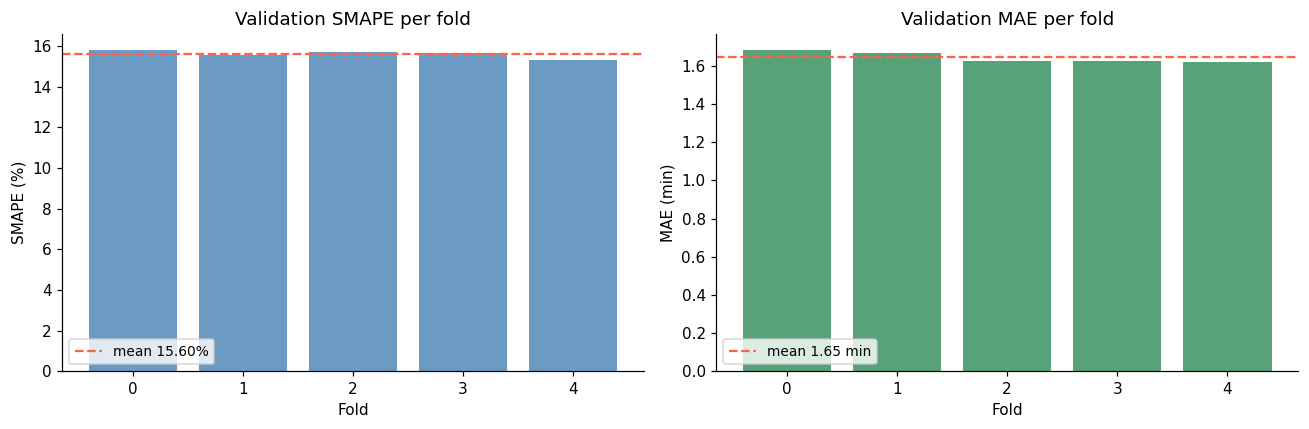

In [60]:
# Visualise CV results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

folds = cv_df['fold'].values

axes[0].bar(folds, cv_df['smape'], color='steelblue', alpha=0.8)
axes[0].axhline(cv_df['smape'].mean(), color='tomato', linestyle='--',
                label=f"mean {cv_df['smape'].mean():.2f}%")
axes[0].set_xticks(folds)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('SMAPE (%)')
axes[0].set_title('Validation SMAPE per fold')
axes[0].legend(fontsize=9)

axes[1].bar(folds, cv_df['mae'], color='seagreen', alpha=0.8)
axes[1].axhline(cv_df['mae'].mean(), color='tomato', linestyle='--',
                label=f"mean {cv_df['mae'].mean():.2f} min")
axes[1].set_xticks(folds)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('MAE (min)')
axes[1].set_title('Validation MAE per fold')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

## 5. Final Model — Train on All Trainval, Evaluate on Test

In [62]:
trainval_idx = splitter.get_trainval_indices()
test_idx     = splitter.test_indices

df_trainval = df.loc[trainval_idx]
df_test     = df.loc[test_idx]

t0 = time.time()
X_tv, y_tv, X_test, y_test, final_feature_names = build_features(df_trainval, df_test)
print(f"Feature build time: {time.time() - t0:.1f}s")

t0 = time.time()
et_final = RandomForestRegressor(
        n_estimators=100, max_features=0.05,
        min_samples_split=20, random_state=42, n_jobs=-1,
    
)
et_final.fit(X_tv, y_tv)
print(f"Training time     : {time.time() - t0:.1f}s")

y_pred_tv   = et_final.predict(X_tv)
y_pred_test = et_final.predict(X_test)

print()
print("=" * 70)
print("Final evaluation")
print("=" * 70)
evaluate(y_tv,   y_pred_tv,   'trainval')
evaluate(y_test, y_pred_test, 'TEST')

Feature build time: 12.5s
Training time     : 0.4s

Final evaluation
  trainval      SMAPE=  8.44%  MAE= 0.87 min  MAPE=  8.90%  R²=0.9211
  TEST          SMAPE= 14.76%  MAE= 1.54 min  MAPE= 16.16%  R²=0.7169


{'smape': np.float64(14.763197000380043),
 'mae': np.float64(1.5430240605946322),
 'mape': np.float64(16.158338041610275),
 'r2': np.float64(0.7168642708866344)}

## 6. Feature Importance

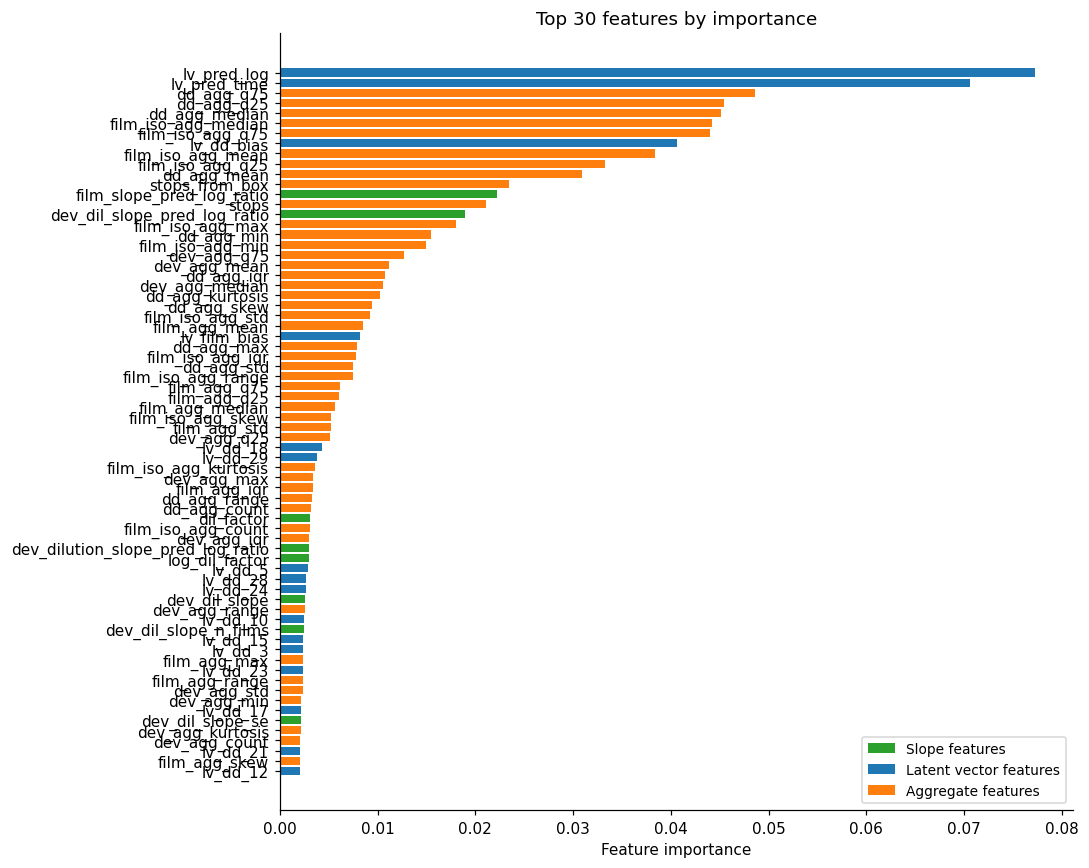

Cumulative importance — top 10: 48.7%  top 30: 89.7%


In [63]:
imp = pd.Series(et_final.feature_importances_, index=final_feature_names).sort_values(ascending=False)
top30 = imp.head(70)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#1f77b4' if 'lv_' in n else
          '#2ca02c' if any(x in n for x in ['slope', 'accel', 'dil']) else
          '#ff7f0e' for n in top30.index]
ax.barh(top30.index[::-1], top30.values[::-1], color=colors[::-1])
ax.set_xlabel('Feature importance')
ax.set_title('Top 30 features by importance')

# Legend patches
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Slope features'),
    Patch(facecolor='#1f77b4', label='Latent vector features'),
    Patch(facecolor='#ff7f0e', label='Aggregate features'),
]
ax.legend(handles=legend_elements, fontsize=9, loc='lower right')

plt.tight_layout()
plt.show()

print(f"Cumulative importance — top 10: {top30.head(10).sum()*100:.1f}%  "
      f"top 30: {top30.sum()*100:.1f}%")

In [64]:
# Importance breakdown by feature group
groups = {
    'Latent vectors': [n for n in final_feature_names if n.startswith('lv_')],
    'Slope features': [n for n in final_feature_names
                       if any(x in n for x in ['slope', 'accel', 'pred_log_ratio'])],
    'Aggregate features': [n for n in final_feature_names
                           if any(x in n for x in ['_agg_', 'dil_factor', 'is_box_iso'])],
    'Other': [],
}
covered = set()
for k, v in groups.items():
    covered |= set(v)
groups['Other'] = [n for n in final_feature_names if n not in covered]

print("Feature group importances:")
for group, names in groups.items():
    total = imp[names].sum() * 100
    print(f"  {group:22s}: {len(names):3d} features  {total:5.1f}%")

Feature group importances:
  Latent vectors        :  65 features   30.6%
  Slope features        :  17 features    6.8%
  Aggregate features    :  51 features   58.0%
  Other                 :   3 features    4.6%


## 7. Error Analysis

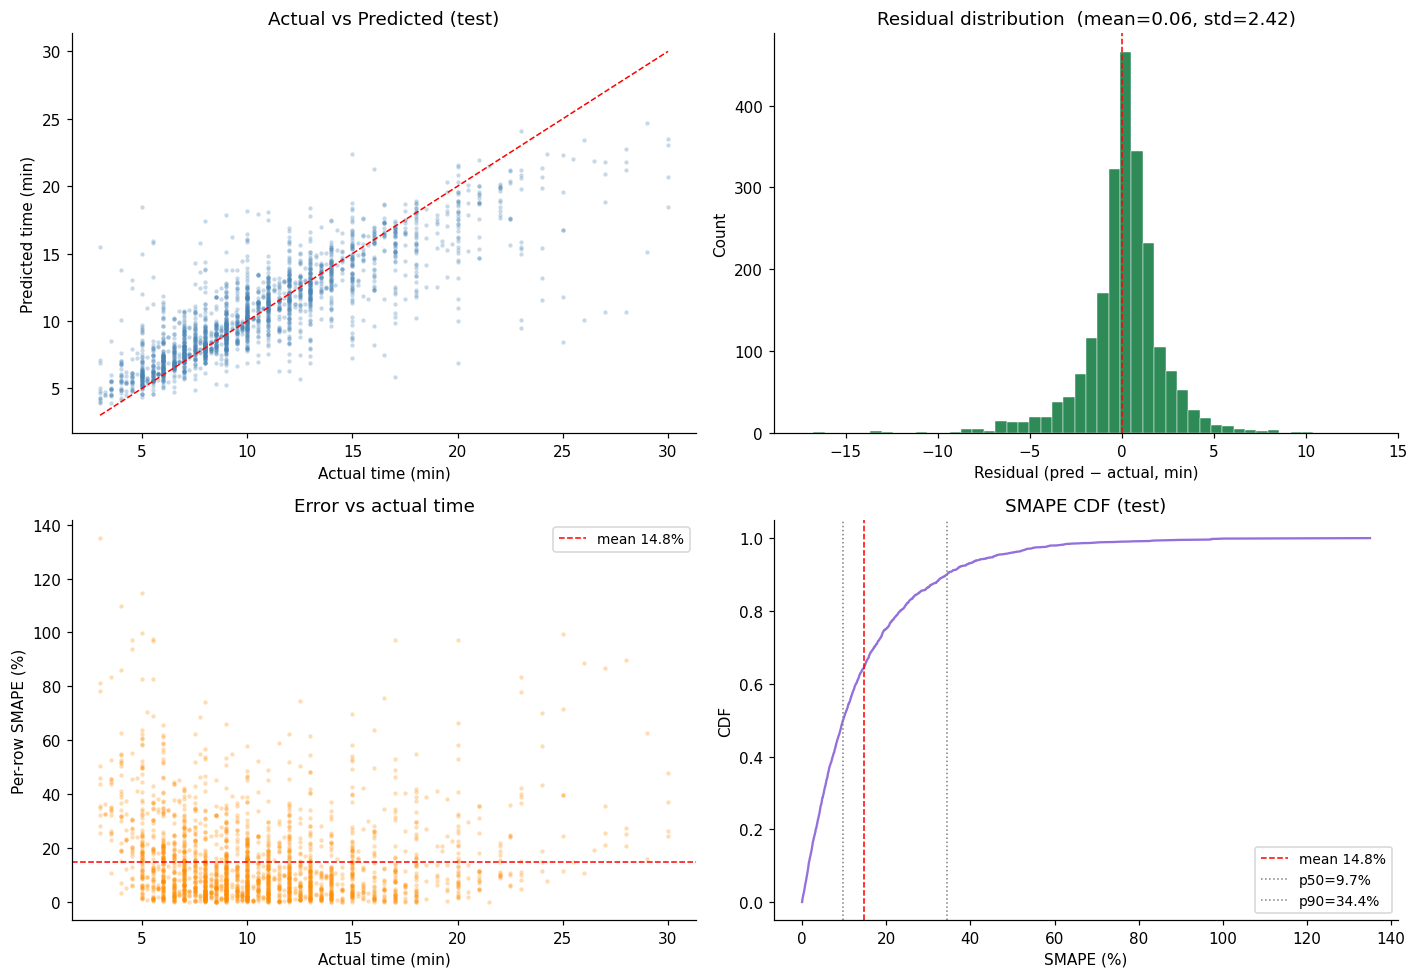

In [65]:
# Residual analysis on test set
residuals = y_pred_test - y_test
smape_per_row = 2 * np.abs(y_pred_test - y_test) / (np.abs(y_pred_test) + np.abs(y_test)) * 100

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# Actual vs predicted
mn, mx = min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.3, s=8, color='steelblue', linewidths=0)
axes[0, 0].plot([mn, mx], [mn, mx], 'r--', linewidth=1)
axes[0, 0].set_xlabel('Actual time (min)')
axes[0, 0].set_ylabel('Predicted time (min)')
axes[0, 0].set_title('Actual vs Predicted (test)')

# Residual distribution
axes[0, 1].hist(residuals, bins=50, color='seagreen', edgecolor='white', linewidth=0.3)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Residual (pred − actual, min)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title(f'Residual distribution  (mean={residuals.mean():.2f}, std={residuals.std():.2f})')

# SMAPE vs actual time
axes[1, 0].scatter(y_test, smape_per_row, alpha=0.3, s=8, color='darkorange', linewidths=0)
axes[1, 0].axhline(smape_per_row.mean(), color='red', linestyle='--', linewidth=1,
                   label=f'mean {smape_per_row.mean():.1f}%')
axes[1, 0].set_xlabel('Actual time (min)')
axes[1, 0].set_ylabel('Per-row SMAPE (%)')
axes[1, 0].set_title('Error vs actual time')
axes[1, 0].legend(fontsize=9)

# SMAPE CDF
sorted_smape = np.sort(smape_per_row)
cdf = np.arange(1, len(sorted_smape) + 1) / len(sorted_smape)
axes[1, 1].plot(sorted_smape, cdf, color='mediumpurple', linewidth=1.5)
axes[1, 1].axvline(smape_per_row.mean(), color='red', linestyle='--', linewidth=1,
                   label=f'mean {smape_per_row.mean():.1f}%')
for pct, val in [(50, np.percentile(smape_per_row, 50)),
                 (90, np.percentile(smape_per_row, 90))]:
    axes[1, 1].axvline(val, color='gray', linestyle=':', linewidth=1,
                       label=f'p{pct}={val:.1f}%')
axes[1, 1].set_xlabel('SMAPE (%)')
axes[1, 1].set_ylabel('CDF')
axes[1, 1].set_title('SMAPE CDF (test)')
axes[1, 1].legend(fontsize=9)

plt.tight_layout()
plt.show()

In [66]:
# Worst predictions
test_rows = df_test[['Film', 'Developer', 'Dilution', 'ASA/ISO', '35mm']].copy()
test_rows['predicted'] = y_pred_test.round(2)
test_rows['smape']     = smape_per_row.round(2)
test_rows['residual']  = residuals.round(2)

print("Worst 15 predictions by SMAPE (test set):")
display(test_rows.sort_values('smape', ascending=False).head(15))

Worst 15 predictions by SMAPE (test set):


,Film,Developer,Dilution,ASA/ISO,35mm,predicted,smape,residual
7086,Kodak Double-X (5222),Rodinal,1+100,25,3.0,15.46,134.99,12.46
2632,Eastman 5363,HC-110,F,25,5.0,18.46,114.75,13.46
10770,Tasma Mikrat 200,Kalogen,1+60,25,4.0,13.76,109.90,9.76
10669,Svema 200 Reporter,Rodinal,1+25,200,5.0,14.97,99.85,9.97
5402,Ilford Delta 100 Pro,Hypercat,1+1+300,80,25.0,8.41,99.29,-16.59
10693,Svema FN64,Kalogen,1+60,32,5.5,15.96,97.47,10.46
5119,Ilford HP5+,Neofin Blue,1+10,400,4.5,13.03,97.31,8.53
689,Argenti Protopan 400,Acufine,stock,400,17.0,5.87,97.31,-11.13
9363,Low Speed B&W Print Film,HC-110,A,3,20.0,6.91,97.25,-13.09
3492,FPP Dracula,Kalogen,1+60,32,5.5,15.80,96.73,10.30


In [67]:
# Error breakdown by stops bucket
stops_test = df_test['stops'].values
bins = [-np.inf, -1.5, -0.5, 0.5, 1.5, 2.5, np.inf]
labels = ['< -1.5', '-1.5–-0.5', '-0.5–0.5', '0.5–1.5', '1.5–2.5', '> 2.5']
bucket = pd.cut(stops_test, bins=bins, labels=labels)

bucket_df = pd.DataFrame({
    'bucket': bucket,
    'smape': smape_per_row,
    'mae': np.abs(residuals),
    'n': 1,
})

summary = bucket_df.groupby('bucket', observed=True).agg(
    n=('n', 'sum'),
    smape_mean=('smape', 'mean'),
    smape_median=('smape', 'median'),
    mae_mean=('mae', 'mean'),
).reset_index()

print("Error breakdown by push/pull bucket:")
display(summary.round(2))

Error breakdown by push/pull bucket:


,bucket,n,smape_mean,smape_median,mae_mean
0,< -1.5,132,17.36,9.36,1.54
1,-1.5–-0.5,286,14.80,9.36,1.51
2,-0.5–0.5,1199,15.51,10.75,1.53
3,0.5–1.5,331,12.87,8.62,1.41
4,1.5–2.5,200,12.09,9.06,1.62
5,> 2.5,95,13.84,7.90,2.12


In [68]:
# Final performance summary
cv_smape_mean = cv_df['smape'].mean()
cv_smape_std  = cv_df['smape'].std()
test_smape    = smape(y_test, y_pred_test)
test_mae      = np.mean(np.abs(y_test - y_pred_test))

print("=" * 50)
print("Final Performance Summary")
print("=" * 50)
print(f"  CV SMAPE  : {cv_smape_mean:.2f}% ± {cv_smape_std:.2f}%")
print(f"  Test SMAPE: {test_smape:.2f}%")
print(f"  Test MAE  : {test_mae:.2f} min")
print(f"  Features  : {X_tv.shape[1]}")

Final Performance Summary
  CV SMAPE  : 15.60% ± 0.19%
  Test SMAPE: 14.76%
  Test MAE  : 1.54 min
  Features  : 136
